In [13]:
# 필요한 라이브러리 import
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.layers import Conv2D, Activation, BatchNormalization, Input, Dropout
from keras.layers import AveragePooling2D, Flatten, MaxPooling2D, Dense
from keras.models import Model
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.models import load_model

In [2]:
# 학습과 관련된 파라미터 설정
num_classes = 10
batch_size = 64
epochs = 150
steps_per_epoch =  int(40000/batch_size)

In [3]:
# epoch에 따라 learning rate에 변화를 주기 위한 함수
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 80:
        lrate = 0.005
    if epoch > 100:
        lrate = 0.003
    if epoch > 120:
        lrate = 0.001
    return lrate

train_x shape: (40000, 32, 32, 3)
40000 train samples


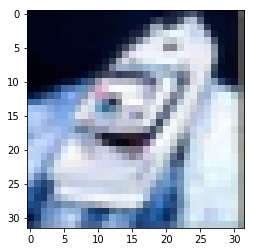

In [4]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

train_x, train_y = load_data()
print('train_x shape:', train_x.shape)
print(train_x.shape[0], 'train samples')
plt.imshow(train_x[2])
plt.show()

In [5]:
# random state는 전체 데이터셋에서 train set의 비율을 의미함 0~1 사이의 값을 입력함
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y,  test_size=0.2, random_state=0)

# z-score normalization: 표준편차를 단위로서 보았을 때 측정치가 평균에서 얼마만큼 일탈하였는가를 보는 것이다. 
#           개인의 측정치 X와 평균치 M과의 차를 표준편차(SD)로 나눈 수이다.
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7) # 각 원소와 평균과의 차이를 표준편차로 나눔(ppt에 나옴 -> normalized data)
x_test = (x_test-mean)/(std+1e-7)

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((32000, 32, 32, 3), (8000, 32, 32, 3), (32000, 10), (8000, 10))

In [6]:
def simple_net(x,kernel_size=32, dropsize=0.2):
    for i in range(3):
        x = Conv2D(kernel_size,(3,3), padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropsize)(x)
    return x

In [7]:
inputs = Input(shape=x_train.shape[1:]) # 텐서로 만들어줌
x = simple_net(inputs)
x = simple_net(x,kernel_size=64, dropsize=0.3)
x = simple_net(x,kernel_size=128, dropsize=0.4)
x = simple_net(x,kernel_size=256, dropsize=0.5)
x = AveragePooling2D(pool_size=2)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activat

In [8]:
# opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.h5'

In [10]:
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(x_train)

In [12]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              workers=4,
                              validation_data=(x_test, y_test),
                              callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
625/625 [==============================] - 40s 64ms/step - loss: 1.7489 - acc: 0.3943 - val_loss: 1.6735 - val_acc: 0.4708

Epoch 00001: val_loss improved from inf to 1.67349, saving model to ./model/01-1.6735.h5
Epoch 2/150
625/625 [==============================] - 35s 56ms/step - loss: 1.2639 - acc: 0.5512 - val_loss: 1.2418 - val_acc: 0.5885

Epoch 00002: val_loss improved from 1.67349 to 1.24180, saving model to ./model/02-1.2418.h5
Epoch 3/150
625/625 [==============================] - 35s 55ms/step - loss: 1.0622 - acc: 0.6271 - val_loss: 1.0813 - val_acc: 0.6386

Epoch 00003: val_loss improved from 1.24180 to 1.08132, saving model to ./model/03-1.0813.h5
Epoch 4/150
625/625 [==============================] - 35s 56ms/step - loss: 0.9290 - acc: 0.6778 - val_loss: 0.7924 - val_acc: 0.7268

Epoch 00004: val_loss improved from 1.08132 to 0.79245, saving model to ./model/04-0.7924.h5
Epoch 5/150
625/625 [===================


Epoch 00038: val_loss improved from 0.38395 to 0.37119, saving model to ./model/38-0.3712.h5
Epoch 39/150
625/625 [==============================] - 35s 56ms/step - loss: 0.2859 - acc: 0.9016 - val_loss: 0.3971 - val_acc: 0.8746

Epoch 00039: val_loss did not improve from 0.37119
Epoch 40/150
625/625 [==============================] - 35s 56ms/step - loss: 0.2812 - acc: 0.9015 - val_loss: 0.4459 - val_acc: 0.8666

Epoch 00040: val_loss did not improve from 0.37119
Epoch 41/150
625/625 [==============================] - 34s 55ms/step - loss: 0.2754 - acc: 0.9040 - val_loss: 0.3800 - val_acc: 0.8814

Epoch 00041: val_loss did not improve from 0.37119
Epoch 42/150
625/625 [==============================] - 34s 55ms/step - loss: 0.2691 - acc: 0.9054 - val_loss: 0.3896 - val_acc: 0.8771

Epoch 00042: val_loss did not improve from 0.37119
Epoch 43/150
625/625 [==============================] - 34s 55ms/step - loss: 0.2691 - acc: 0.9054 - val_loss: 0.3996 - val_acc: 0.8751

Epoch 00043: val_


Epoch 00081: val_loss did not improve from 0.35663
Epoch 82/150
625/625 [==============================] - 35s 56ms/step - loss: 0.4707 - acc: 0.8384 - val_loss: 0.5038 - val_acc: 0.8423

Epoch 00082: val_loss did not improve from 0.35663
Epoch 83/150
625/625 [==============================] - 35s 56ms/step - loss: 0.4192 - acc: 0.8552 - val_loss: 0.5286 - val_acc: 0.8340

Epoch 00083: val_loss did not improve from 0.35663
Epoch 84/150
625/625 [==============================] - 35s 56ms/step - loss: 0.4121 - acc: 0.8572 - val_loss: 0.6096 - val_acc: 0.8147

Epoch 00084: val_loss did not improve from 0.35663
Epoch 85/150
625/625 [==============================] - 35s 56ms/step - loss: 0.3927 - acc: 0.8638 - val_loss: 0.4867 - val_acc: 0.8424

Epoch 00085: val_loss did not improve from 0.35663
Epoch 86/150
625/625 [==============================] - 34s 55ms/step - loss: 0.3916 - acc: 0.8658 - val_loss: 0.4797 - val_acc: 0.8544

Epoch 00086: val_loss did not improve from 0.35663
Epoch 87

625/625 [==============================] - 35s 56ms/step - loss: 0.1111 - acc: 0.9606 - val_loss: 0.3844 - val_acc: 0.9024

Epoch 00125: val_loss did not improve from 0.33367
Epoch 126/150
625/625 [==============================] - 35s 55ms/step - loss: 0.1100 - acc: 0.9614 - val_loss: 0.3719 - val_acc: 0.9031

Epoch 00126: val_loss did not improve from 0.33367
Epoch 127/150
625/625 [==============================] - 35s 56ms/step - loss: 0.1093 - acc: 0.9612 - val_loss: 0.3487 - val_acc: 0.9071

Epoch 00127: val_loss did not improve from 0.33367
Epoch 128/150
625/625 [==============================] - 35s 56ms/step - loss: 0.1047 - acc: 0.9629 - val_loss: 0.3667 - val_acc: 0.9050

Epoch 00128: val_loss did not improve from 0.33367
Epoch 129/150
625/625 [==============================] - 35s 56ms/step - loss: 0.1045 - acc: 0.9630 - val_loss: 0.3626 - val_acc: 0.9061

Epoch 00129: val_loss did not improve from 0.33367
Epoch 130/150
625/625 [==============================] - 34s 55ms/ste

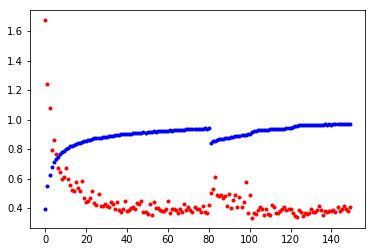

In [14]:
# y_loss에 학습셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [15]:
model = load_model('./model/102-0.3337.h5')

In [16]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

8000/8000 [==============================] - 2s 305us/step

Test result: 90.000 loss: 0.334


In [17]:
model = load_model('./baseline_code_final (2)/model/149-0.3323################.h5')

In [18]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

8000/8000 [==============================] - 2s 309us/step

Test result: 20.625 loss: 7.894
